In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Using device: cpu


In [53]:
def generate_sphere_data(n_samples, intrinsic_dim=10, ambient_dim=50, radius=1.0):
    """
    Generate points uniformly on a sphere.

    Args:
        n_samples: Number of points to generate
        intrinsic_dim: Dimension of the sphere (10 means 10D sphere surface)
        ambient_dim: Dimension of embedding space (50D)
        radius: Radius of the sphere

    Returns:
        data: (n_samples, ambient_dim) array of points on sphere
    """
    # Generate points from standard normal distribution
    # in (intrinsic_dim + 1) dimensions (need d+1 for d-sphere)
    points = np.random.randn(n_samples, intrinsic_dim + 1)

    # Normalize to unit sphere
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    points_on_sphere = radius * points / norms

    # Embed in higher dimensional space by padding with zeros
    # (This creates a sphere that lives in a linear subspace of R^50)
    embedded = np.zeros((n_samples, ambient_dim))
    embedded[:, :intrinsic_dim + 1] = points_on_sphere

    return embedded.astype(np.float32)

print(f"  Expected: radius = 1.0")

  Expected: radius = 1.0


In [54]:
# Generate training, validation, and test sets
n_train = 5000
n_val = 1000
n_test = 1000

train_data = generate_sphere_data(n_train, intrinsic_dim=10, ambient_dim=50)
val_data = generate_sphere_data(n_val, intrinsic_dim=10, ambient_dim=50)
test_data = generate_sphere_data(n_test, intrinsic_dim=10, ambient_dim=50)

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nData statistics:")
print(f"  Mean norm: {np.mean(np.linalg.norm(train_data, axis=1)):.4f}")
print(f"  Std norm: {np.std(np.linalg.norm(train_data, axis=1)):.6f}")

Training data shape: (5000, 50)
Validation data shape: (1000, 50)
Test data shape: (1000, 50)

Data statistics:
  Mean norm: 1.0000
  Std norm: 0.000000


In [55]:
class BiaslessAutoencoder(nn.Module):
    """
    Simple autoencoder with no biases and ReLU activations.
    Symmetric encoder-decoder architecture.
    """
    def __init__(self, input_dim=50, latent_dim=10, hidden_dim=128):
        super(BiaslessAutoencoder, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim, bias=False)
        )

        # Decoder (symmetric)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim, bias=False)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

In [56]:
test_model = BiaslessAutoencoder(input_dim=50, latent_dim=10, hidden_dim=128)
test_input = torch.randn(5, 50)
test_output, test_latent = test_model(test_input)

print(f"Model architecture:")
print(f"  Input dim: {test_model.input_dim}")
print(f"  Latent dim: {test_model.latent_dim}")
print(f"  Test input shape: {test_input.shape}")
print(f"  Test output shape: {test_output.shape}")
print(f"  Test latent shape: {test_latent.shape}")
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters()):,}")

Model architecture:
  Input dim: 50
  Latent dim: 10
  Test input shape: torch.Size([5, 50])
  Test output shape: torch.Size([5, 50])
  Test latent shape: torch.Size([5, 10])

Total parameters: 48,128


In [72]:
def train_autoencoder(model, train_data, val_data,
                     n_epochs=500, batch_size=128, lr=1e-3,
                     patience=50, min_delta=1e-6):
    """
    Train autoencoder with early stopping based on validation loss.

    Args:
        model: Autoencoder model
        train_data: Training data (numpy array)
        val_data: Validation data (numpy array)
        n_epochs: Maximum number of epochs
        batch_size: Batch size for training
        lr: Learning rate
        patience: Number of epochs to wait for improvement
        min_delta: Minimum change to consider as improvement

    Returns:
        model: Trained model
        history: Dictionary with training history
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
    criterion = nn.MSELoss()

    # Create data loaders
    train_dataset = TensorDataset(torch.FloatTensor(train_data))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_tensor = torch.FloatTensor(val_data).to(device)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print(f"Training autoencoder with latent_dim={model.latent_dim}")
    print(f"=" * 60)

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch in train_loader:
            x = batch[0].to(device)

            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_recon, _ = model(val_tensor)
            val_loss = criterion(val_recon, val_tensor).item()

        avg_train_loss = np.mean(train_losses)

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['epoch'].append(epoch)

        # Print progress every 50 epochs
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{n_epochs} | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f}")

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Training completed!")
    print(f"Final validation loss: {best_val_loss:.6f}")
    print("=" * 60)

    return model, history

In [73]:

print("Testing training function with latent_dim=10...")
test_model = BiaslessAutoencoder(input_dim=50, latent_dim=10, hidden_dim=128)
trained_model, test_history = train_autoencoder(
    test_model, train_data, val_data,
    n_epochs=200, batch_size=128, lr=1e-3,
    patience=30
)

Testing training function with latent_dim=10...
Training autoencoder with latent_dim=10
Epoch   1/200 | Train Loss: 0.016456 | Val Loss: 0.009498
Epoch  50/200 | Train Loss: 0.000957 | Val Loss: 0.001131
Epoch 100/200 | Train Loss: 0.000780 | Val Loss: 0.000982
Epoch 150/200 | Train Loss: 0.000818 | Val Loss: 0.001026
Epoch 200/200 | Train Loss: 0.000682 | Val Loss: 0.000900
Training completed!
Final validation loss: 0.000897


In [74]:
def sweep_latent_dimensions(train_data, val_data, test_data,
                           latent_dims=[5, 8, 10, 12, 15, 20, 25],
                           hidden_dim=128, n_epochs=500,
                           batch_size=128, lr=1e-3, patience=30):
    """
    Train autoencoders with different latent dimensions.

    Returns:
        results: Dictionary containing trained models and metrics
    """
    results = {
        'models': {},
        'train_loss': {},
        'val_loss': {},
        'test_loss': {},
        'histories': {}
    }

    test_tensor = torch.FloatTensor(test_data).to(device)
    criterion = nn.MSELoss()

    print("\n" + "="*70)
    print("SWEEPING OVER LATENT DIMENSIONS")
    print("="*70 + "\n")

    for latent_dim in latent_dims:
        print(f"\n{'='*70}")
        print(f"Training with latent_dim = {latent_dim}")
        print(f"{'='*70}")

        # Create and train model
        model = BiaslessAutoencoder(
            input_dim=train_data.shape[1],
            latent_dim=latent_dim,
            hidden_dim=hidden_dim
        )

        trained_model, history = train_autoencoder(
            model, train_data, val_data,
            n_epochs=n_epochs,
            batch_size=batch_size,
            lr=lr,
            patience=patience
        )

        # Evaluate on test set
        trained_model.eval()
        with torch.no_grad():
            test_recon, _ = trained_model(test_tensor)
            test_loss = criterion(test_recon, test_tensor).item()

        # Store results
        results['models'][latent_dim] = trained_model
        results['train_loss'][latent_dim] = history['train_loss'][-1]
        results['val_loss'][latent_dim] = history['val_loss'][-1]
        results['test_loss'][latent_dim] = test_loss
        results['histories'][latent_dim] = history

        print(f"\nTest Loss for latent_dim={latent_dim}: {test_loss:.6f}\n")

    return results

In [95]:
# Run the sweep
latent_dims_to_test = [5, 8, 9, 10, 11, 12, 15]
sweep_results = sweep_latent_dimensions(
    train_data, val_data, test_data,
    latent_dims=latent_dims_to_test,
    hidden_dim=128,
    n_epochs=300,
    batch_size=128,
    lr=1e-3,
    patience=30
)

print("\n" + "="*70)
print("SWEEP COMPLETE")
print("="*70)
print("\nSummary of Results:")
print(f"{'Latent Dim':<12} {'Train Loss':<15} {'Val Loss':<15} {'Test Loss':<15}")
print("-" * 60)
for dim in latent_dims_to_test:
    print(f"{dim:<12} {sweep_results['train_loss'][dim]:<15.6f} "
          f"{sweep_results['val_loss'][dim]:<15.6f} "
          f"{sweep_results['test_loss'][dim]:<15.6f}")


SWEEPING OVER LATENT DIMENSIONS


Training with latent_dim = 5
Training autoencoder with latent_dim=5
Epoch   1/300 | Train Loss: 0.017170 | Val Loss: 0.013115
Epoch  50/300 | Train Loss: 0.007497 | Val Loss: 0.008551
Epoch 100/300 | Train Loss: 0.006725 | Val Loss: 0.008162
Epoch 150/300 | Train Loss: 0.006248 | Val Loss: 0.008080

Early stopping at epoch 166
Best validation loss: 0.008024
Training completed!
Final validation loss: 0.008024

Test Loss for latent_dim=5: 0.008384


Training with latent_dim = 8
Training autoencoder with latent_dim=8
Epoch   1/300 | Train Loss: 0.016917 | Val Loss: 0.011771
Epoch  50/300 | Train Loss: 0.003284 | Val Loss: 0.004002
Epoch 100/300 | Train Loss: 0.002573 | Val Loss: 0.003414
Epoch 150/300 | Train Loss: 0.002249 | Val Loss: 0.003137
Epoch 200/300 | Train Loss: 0.002053 | Val Loss: 0.003050
Epoch 250/300 | Train Loss: 0.001923 | Val Loss: 0.003069

Early stopping at epoch 256
Best validation loss: 0.003015
Training completed!
Final validation 

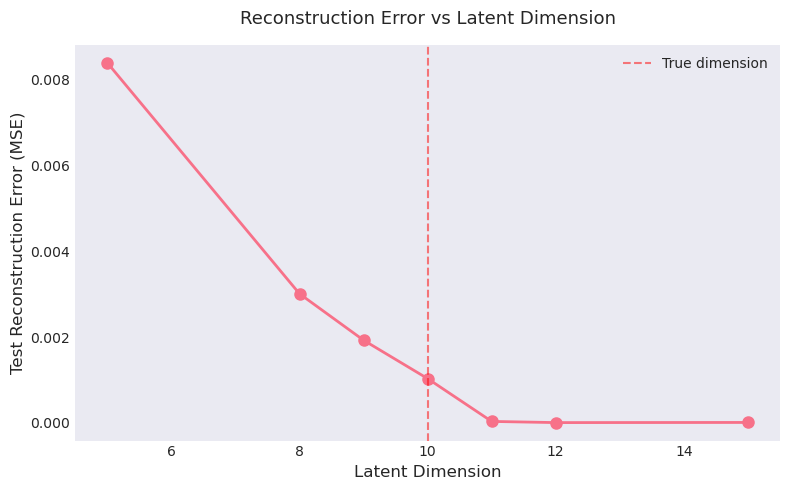


Error Reduction:
From → To       Absolute        Relative (%)   
---------------------------------------------
 5 → 8         0.005377        64.13          
 8 → 9         0.001081        35.96          
 9 → 10        0.000893        46.39          
10 → 11        0.000997        96.53          
11 → 12        0.000027        75.98          
12 → 15        -0.000003       -39.25         


In [96]:
def plot_reconstruction_errors(results, latent_dims):
    """
    Plot reconstruction errors vs latent dimension (elbow plot).
    """
    fig, ax = plt.subplots(figsize=(8, 5))

    # Extract errors
    test_errors = [results['test_loss'][d] for d in latent_dims]

    # Plot
    ax.plot(latent_dims, test_errors, 'o-', linewidth=2, markersize=8)

    # Labels
    ax.set_xlabel('Latent Dimension', fontsize=12)
    ax.set_ylabel('Test Reconstruction Error (MSE)', fontsize=12)
    ax.set_title('Reconstruction Error vs Latent Dimension', fontsize=13, pad=15)

    # Add vertical line at true dimension (10)
    ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='True dimension')
    ax.legend()

    # Clean styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

    # Print error reduction
    print("\nError Reduction:")
    print(f"{'From → To':<15} {'Absolute':<15} {'Relative (%)':<15}")
    print("-" * 45)
    for i in range(len(latent_dims) - 1):
        d1, d2 = latent_dims[i], latent_dims[i+1]
        e1, e2 = results['test_loss'][d1], results['test_loss'][d2]
        abs_reduction = e1 - e2
        rel_reduction = 100 * abs_reduction / e1 if e1 > 0 else 0
        print(f"{d1:>2d} → {d2:<2d}        {abs_reduction:<15.6f} {rel_reduction:<15.2f}")

plot_reconstruction_errors(sweep_results, latent_dims_to_test)

In [97]:
def plot_reconstruction_quality(model, data, n_samples=500):
    """
    Plot histogram of R^2 between input and output for each point.
    Also show some example reconstructions.
    """
    model = model.to(device)
    model.eval()

    # Sample data
    sample_data = data[:n_samples]
    sample_tensor = torch.FloatTensor(sample_data).to(device)

    # Get reconstructions
    with torch.no_grad():
        recon, _ = model(sample_tensor)

    recon_np = recon.cpu().numpy()

    # Compute R^2 for each point
    r2_scores = []
    for i in range(n_samples):
        y_true = sample_data[i]
        y_pred = recon_np[i]

        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        r2_scores.append(r2)

    r2_scores = np.array(r2_scores)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram of R^2 scores
    axes[0].hist(r2_scores, bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('R² Score', fontsize=11)
    axes[0].set_ylabel('Count', fontsize=11)
    axes[0].set_title(f'Distribution of R² Scores\n(latent_dim={model.latent_dim})', fontsize=12)
    axes[0].axvline(np.mean(r2_scores), color='red', linestyle='--',
                    linewidth=2, label=f'Mean: {np.mean(r2_scores):.4f}')
    axes[0].legend()
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].grid(False)

    # Example reconstruction: scatter plot of true vs predicted values
    # Take first point as example
    example_idx = 0
    axes[1].scatter(sample_data[example_idx], recon_np[example_idx], alpha=0.6, s=30)

    # Perfect reconstruction line
    min_val = min(sample_data[example_idx].min(), recon_np[example_idx].min())
    max_val = max(sample_data[example_idx].max(), recon_np[example_idx].max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2,
                 label='Perfect reconstruction')

    axes[1].set_xlabel('True Value', fontsize=11)
    axes[1].set_ylabel('Reconstructed Value', fontsize=11)
    axes[1].set_title(f'Example Point Reconstruction\n(R²={r2_scores[example_idx]:.4f})', fontsize=12)
    axes[1].legend()
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()

    return r2_scores


Latent Dimension: 5


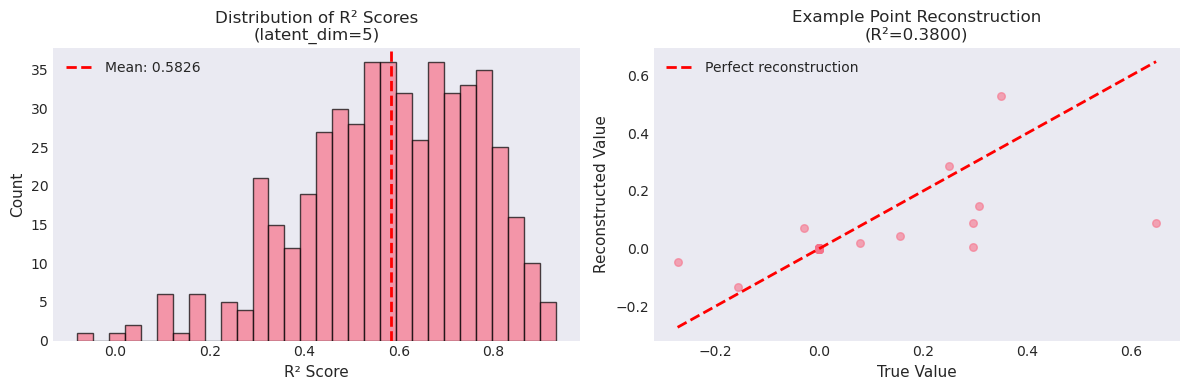


Latent Dimension: 8


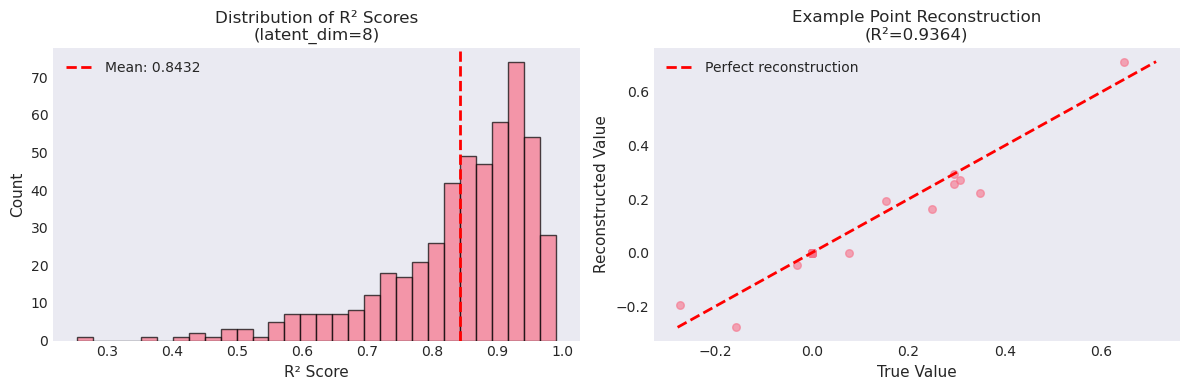


Latent Dimension: 10


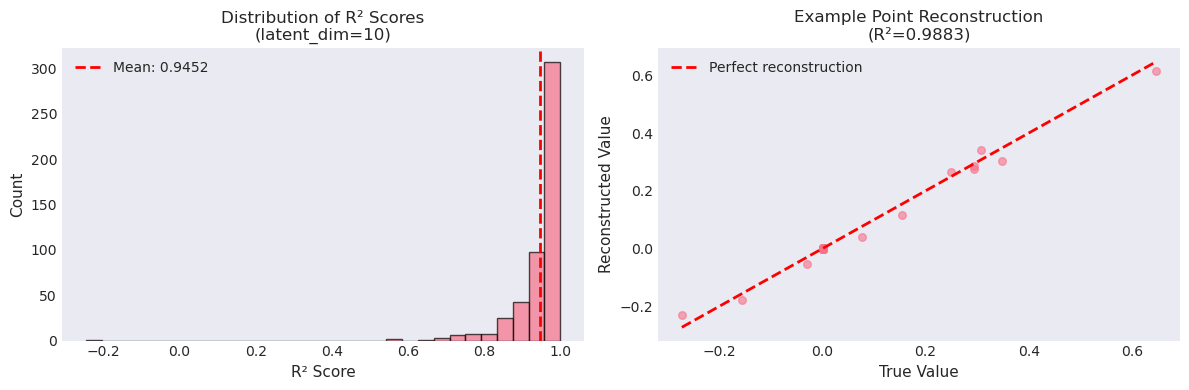


Latent Dimension: 12


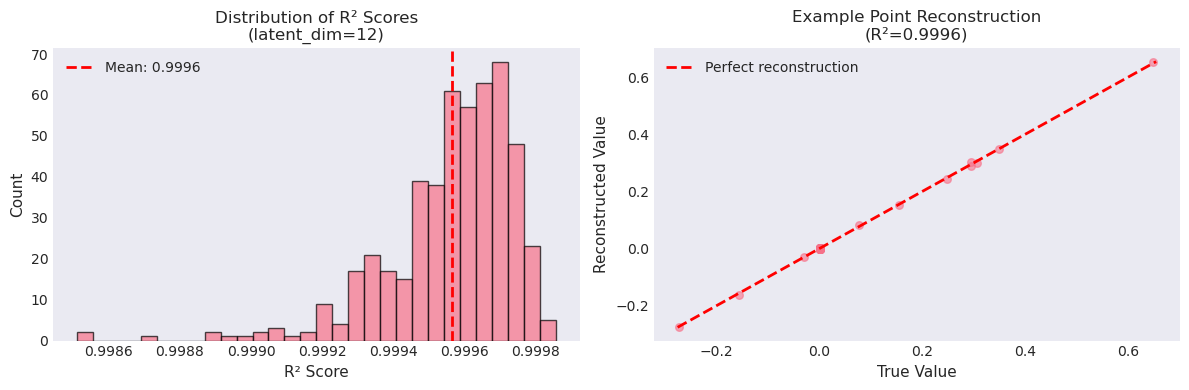

In [98]:
# Test with different latent dimensions
for latent_dim in [5, 8, 10, 12]:
    if latent_dim in sweep_results['models']:
        print(f"\n{'='*60}")
        print(f"Latent Dimension: {latent_dim}")
        print(f"{'='*60}")
        model = sweep_results['models'][latent_dim]
        r2_scores = plot_reconstruction_quality(model, test_data, n_samples=500)

In [99]:
def compute_jacobian(model, x, latent_dim=None):
    """
    Compute the Jacobian matrix ∂z/∂x for the encoder.

    Args:
        model: Trained autoencoder
        x: Input point (can be single point or batch)
        latent_dim: Latent dimension (if None, infer from model)

    Returns:
        jacobian: (latent_dim, input_dim) Jacobian matrix
    """
    if latent_dim is None:
        latent_dim = model.latent_dim

    input_dim = x.shape[-1]

    # Ensure x requires grad and is 2D
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
    x = x.detach().clone().requires_grad_(True)

    # Compute latent representation
    z = model.encode(x)

    # Compute Jacobian: ∂z/∂x
    jacobian = torch.zeros(latent_dim, input_dim, device=x.device)

    for i in range(latent_dim):
        # Compute gradient of i-th latent dimension w.r.t. input
        if x.grad is not None:
            x.grad.zero_()

        # Create output vector that's 1 for dimension i, 0 elsewhere
        output = torch.zeros_like(z)
        output[0, i] = 1.0

        # Backward pass
        z.backward(output, retain_graph=True)

        # Store gradient (this is the i-th row of Jacobian)
        jacobian[i] = x.grad[0].clone()

    return jacobian.detach().cpu().numpy()


def analyze_jacobian_spectrum(jacobian):
    """
    Perform SVD on Jacobian and analyze the spectrum.

    Args:
        jacobian: (latent_dim, input_dim) matrix

    Returns:
        U, S, Vt: SVD components
        tangent_space: Top singular vectors (tangent directions in input space)
    """
    U, S, Vt = svd(jacobian, full_matrices=False)

    # Normalize singular values
    S_normalized = S / S[0] if S[0] > 0 else S

    # Count significant singular values (threshold at 1% of max)
    threshold = 0.01
    n_significant = np.sum(S_normalized > threshold)

    # Top singular vectors are the tangent directions
    tangent_space = Vt[:n_significant, :]

    return U, S, Vt, tangent_space, n_significant

In [121]:
# Test Jacobian computation on a single point
print("Testing Jacobian computation...")
test_model = sweep_results['models'][11]
test_model.eval()

test_point = torch.FloatTensor(test_data[0]).to(device)
jacobian = compute_jacobian(test_model, test_point)

print(f"\nJacobian shape: {jacobian.shape}")
print(f"Expected: (latent_dim={test_model.latent_dim}, input_dim={test_data.shape[1]})")

# Analyze spectrum
U, S, Vt, tangent_space, n_sig = analyze_jacobian_spectrum(jacobian)

print(f"\nSingular values (top 15):")
for i, sv in enumerate(S[:15]):
    normalized = sv / S[0]
    print(f"  σ_{i+1:2d} = {sv:.6f}  (normalized: {normalized:.6f})")

print(f"\nNumber of significant singular values (>1% of max): {n_sig}")
print(f"Tangent space shape: {tangent_space.shape}")
print(f"  → These are {tangent_space.shape[0]} tangent directions in {tangent_space.shape[1]}D space")

Testing Jacobian computation...

Jacobian shape: (11, 50)
Expected: (latent_dim=11, input_dim=50)

Singular values (top 15):
  σ_ 1 = 3.678412  (normalized: 1.000000)
  σ_ 2 = 1.543654  (normalized: 0.419652)
  σ_ 3 = 1.398231  (normalized: 0.380118)
  σ_ 4 = 1.303676  (normalized: 0.354413)
  σ_ 5 = 1.296750  (normalized: 0.352530)
  σ_ 6 = 1.234301  (normalized: 0.335553)
  σ_ 7 = 1.123176  (normalized: 0.305343)
  σ_ 8 = 1.055383  (normalized: 0.286913)
  σ_ 9 = 0.975842  (normalized: 0.265289)
  σ_10 = 0.889042  (normalized: 0.241692)
  σ_11 = 0.848338  (normalized: 0.230626)

Number of significant singular values (>1% of max): 11
Tangent space shape: (11, 50)
  → These are 11 tangent directions in 50D space


In [101]:
def compute_true_tangent_space(point, intrinsic_dim=10):
    """
    Compute the true tangent space of a sphere analytically.

    For a point on a sphere, the tangent space is all vectors orthogonal to
    the radius vector (the point itself, since sphere is centered at origin).

    Args:
        point: Point on sphere (numpy array, shape (ambient_dim,))
        intrinsic_dim: Intrinsic dimension of sphere (10 for 10D sphere)

    Returns:
        tangent_basis: Orthonormal basis for tangent space (intrinsic_dim, ambient_dim)
    """
    # The sphere lives in first (intrinsic_dim + 1) dimensions
    # For our 10D sphere: dimensions 0-10 are active, 11-49 are all zeros

    active_dims = intrinsic_dim + 1
    point_active = point[:active_dims]

    # Tangent space is orthogonal to the radius vector (point itself)
    # We need (intrinsic_dim) orthonormal vectors perpendicular to point_active

    # Method: Start with standard basis, remove component along point, orthogonalize
    tangent_vectors = []

    # Normalize point to get radius direction
    radius_direction = point_active / np.linalg.norm(point_active)

    # Generate vectors orthogonal to radius
    for i in range(active_dims):
        # Start with i-th standard basis vector
        v = np.zeros(active_dims)
        v[i] = 1.0

        # Remove component along radius
        v_tangent = v - np.dot(v, radius_direction) * radius_direction

        # Normalize
        norm = np.linalg.norm(v_tangent)
        if norm > 1e-10:  # Only keep if not parallel to radius
            v_tangent = v_tangent / norm
            tangent_vectors.append(v_tangent)

    # Should have (intrinsic_dim) vectors now
    tangent_vectors = np.array(tangent_vectors[:intrinsic_dim])

    # Orthogonalize using Gram-Schmidt (to handle any numerical issues)
    tangent_basis = np.zeros((intrinsic_dim, active_dims))
    for i in range(intrinsic_dim):
        v = tangent_vectors[i].copy()
        # Remove components along previous basis vectors
        for j in range(i):
            v -= np.dot(v, tangent_basis[j]) * tangent_basis[j]
        # Normalize
        tangent_basis[i] = v / np.linalg.norm(v)

    # Embed back into full ambient space (pad with zeros)
    tangent_basis_full = np.zeros((intrinsic_dim, len(point)))
    tangent_basis_full[:, :active_dims] = tangent_basis

    return tangent_basis_full


def compare_tangent_spaces(tangent_learned, tangent_true):
    """
    Compare learned tangent space to true tangent space using principal angles.

    Args:
        tangent_learned: (k, d) matrix of learned tangent vectors
        tangent_true: (k, d) matrix of true tangent vectors

    Returns:
        principal_angles: Angles between the two subspaces
        subspace_distance: Maximum principal angle
    """
    # Compute principal angles using SVD
    # See: Björck & Golub (1973) or Knyazev & Argentati (2002)

    # Orthonormalize both bases (should already be, but be safe)
    Q1, _ = np.linalg.qr(tangent_learned.T)
    Q2, _ = np.linalg.qr(tangent_true.T)

    # Compute cosines of principal angles via SVD of Q1.T @ Q2
    M = Q1.T @ Q2
    _, S, _ = svd(M)

    # Clip to [0, 1] to handle numerical issues
    S = np.clip(S, 0, 1)

    # Principal angles
    principal_angles = np.arccos(S)

    # Convert to degrees for interpretability
    principal_angles_deg = np.degrees(principal_angles)

    # Subspace distance (max angle)
    subspace_distance = principal_angles_deg[0]

    return principal_angles_deg, subspace_distance


In [123]:


# Test on multiple points
print("="*70)
print("COMPARING LEARNED VS TRUE TANGENT SPACES")
print("="*70)

n_test_points = 100
test_indices = np.random.choice(len(test_data), n_test_points, replace=False)

model = sweep_results['models'][11]
model.eval()

all_angles = []
all_distances = []
all_singular_values = []

for idx in test_indices:
    point = test_data[idx]
    point_tensor = torch.FloatTensor(point).to(device)

    # Compute learned tangent space (from Jacobian)
    jacobian = compute_jacobian(model, point_tensor)
    U, S, Vt, _, _ = analyze_jacobian_spectrum(jacobian)
    tangent_learned = Vt[:11, :]  # Top 10 singular vectors

    # Compute true tangent space (analytical)
    tangent_true = compute_true_tangent_space(point, intrinsic_dim=10)

    # Compare
    angles, distance = compare_tangent_spaces(tangent_learned, tangent_true)

    all_angles.append(angles)
    all_distances.append(distance)
    all_singular_values.append(S)

all_angles = np.array(all_angles)
all_distances = np.array(all_distances)
all_singular_values = np.array(all_singular_values)

print(f"\nResults across {n_test_points} test points:")
print(f"\nSubspace distances (max principal angle in degrees):")
print(f"  Mean: {np.mean(all_distances):.4f}°")
print(f"  Std:  {np.std(all_distances):.4f}°")
print(f"  Min:  {np.min(all_distances):.4f}°")
print(f"  Max:  {np.max(all_distances):.4f}°")

print(f"\nAll principal angles (mean across points, in degrees):")
for i in range(10):
    mean_angle = np.mean(all_angles[:, i])
    std_angle = np.std(all_angles[:, i])
    print(f"  Angle {i+1:2d}: {mean_angle:6.4f}° ± {std_angle:6.4f}°")

print(f"\nSingular value statistics (normalized by max):")
S_norm = all_singular_values / all_singular_values[:, 0:1]
for i in range(11):
    mean_sv = np.mean(S_norm[:, i])
    std_sv = np.std(S_norm[:, i])
    print(f"  σ_{i+1:2d}: {mean_sv:.4f} ± {std_sv:.4f}")

COMPARING LEARNED VS TRUE TANGENT SPACES

Results across 100 test points:

Subspace distances (max principal angle in degrees):
  Mean: 7.8452°
  Std:  0.7433°
  Min:  5.9055°
  Max:  9.7075°

All principal angles (mean across points, in degrees):
  Angle  1: 7.8452° ± 0.7433°
  Angle  2: 9.0459° ± 0.6166°
  Angle  3: 10.2052° ± 0.5105°
  Angle  4: 11.2573° ± 0.5581°
  Angle  5: 12.2183° ± 0.5197°
  Angle  6: 13.3589° ± 0.6053°
  Angle  7: 14.5152° ± 0.7565°
  Angle  8: 15.8126° ± 0.8497°
  Angle  9: 17.6882° ± 1.0764°
  Angle 10: 21.1234° ± 2.8724°

Singular value statistics (normalized by max):
  σ_ 1: 1.0000 ± 0.0000
  σ_ 2: 0.4583 ± 0.0776
  σ_ 3: 0.4280 ± 0.0725
  σ_ 4: 0.4046 ± 0.0684
  σ_ 5: 0.3849 ± 0.0632
  σ_ 6: 0.3621 ± 0.0576
  σ_ 7: 0.3436 ± 0.0550
  σ_ 8: 0.3236 ± 0.0512
  σ_ 9: 0.3021 ± 0.0466
  σ_10: 0.2789 ± 0.0437
  σ_11: 0.2227 ± 0.0214


In [103]:
def compare_top_k_subspaces(tangent_learned, tangent_true, k):
    """Compare only top k principal directions"""
    tangent_learned_k = tangent_learned[:k, :]
    tangent_true_k = tangent_true[:k, :]
    angles, distance = compare_tangent_spaces(tangent_learned_k, tangent_true_k)
    return angles, distance

# Compare top 5 vs top 10
angles_5, dist_5 = compare_top_k_subspaces(tangent_learned, tangent_true, k=5)
angles_10, dist_10 = compare_top_k_subspaces(tangent_learned, tangent_true, k=10)
angles_15, dist_15 = compare_top_k_subspaces(tangent_learned, tangent_true, k=12)

In [104]:
print("Angles 5")
print(angles_5)
print("Angles 10")
print(angles_10)
print("Angles 15")
print(angles_15)


Angles 5
[24.51846411 34.37080357 57.62705683 80.14973851 89.10910273]
Angles 10
[ 7.56011751 10.00342791 10.66989896 11.58630814 12.82930245 15.07564954
 16.3853695  18.58830683 20.6260796  63.11213257]
Angles 15
[ 7.56011751 10.00342791 10.66989896 11.58630814 12.82930245 15.07564954
 16.3853695  18.58830683 20.6260796  63.11213257]


3d sphere

In [105]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.linalg import svd
import seaborn as sns

def generate_sphere_data_3d(n_samples, intrinsic_dim=2, ambient_dim=10, radius=1.0):
    """
    Generate points uniformly on a 2D sphere (3D surface) embedded in higher dimensions.

    Args:
        n_samples: Number of points to generate
        intrinsic_dim: Dimension of the sphere (2 means 2D sphere = 3D surface)
        ambient_dim: Dimension of embedding space
        radius: Radius of the sphere

    Returns:
        data: (n_samples, ambient_dim) array of points on sphere
        coords: (n_samples, intrinsic_dim+1) original coordinates before padding
    """
    # Generate points from standard normal in (intrinsic_dim + 1) dimensions
    points = np.random.randn(n_samples, intrinsic_dim + 1)

    # Normalize to unit sphere
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    points_on_sphere = radius * points / norms

    # Store the 3D coordinates for visualization
    coords = points_on_sphere.copy()

    # Embed in higher dimensional space
    embedded = np.zeros((n_samples, ambient_dim))
    embedded[:, :intrinsic_dim + 1] = points_on_sphere

    return embedded.astype(np.float32), coords


def extract_learned_manifold_embedding(model, data, method='latent'):
    """
    Extract learned manifold representation for visualization.

    Args:
        model: Trained autoencoder
        data: Input data (n_samples, ambient_dim)
        method: 'latent' = use latent codes, 'reconstruction' = use reconstructions

    Returns:
        embedding: Learned representation
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        data_tensor = torch.FloatTensor(data).to(device)
        x_recon, z = model(data_tensor)

        if method == 'latent':
            return z.cpu().numpy()
        elif method == 'reconstruction':
            # Extract first 3 active dimensions
            return x_recon.cpu().numpy()[:, :3]


def compute_tangent_space_at_point(model, point, device):
    """
    Compute tangent space at a point using Jacobian.

    Args:
        model: Trained autoencoder
        point: Single point (ambient_dim,)
        device: torch device

    Returns:
        tangent_vectors: Top singular vectors (tangent directions)
        singular_values: Corresponding singular values
    """
    point_tensor = torch.FloatTensor(point).to(device).unsqueeze(0)
    point_tensor.requires_grad_(True)

    z = model.encode(point_tensor)
    latent_dim = z.shape[1]
    input_dim = point_tensor.shape[1]

    jacobian = torch.zeros(latent_dim, input_dim, device=device)

    for i in range(latent_dim):
        if point_tensor.grad is not None:
            point_tensor.grad.zero_()

        output = torch.zeros_like(z)
        output[0, i] = 1.0
        z.backward(output, retain_graph=True)
        jacobian[i] = point_tensor.grad[0].clone()

    # SVD
    J_np = jacobian.detach().cpu().numpy()
    U, S, Vt = svd(J_np, full_matrices=False)

    return Vt, S  # Vt rows are tangent directions


def plot_3d_manifolds_comparison(true_coords, learned_coords,
                                  title="True vs Learned Manifold"):
    """
    Plot true and learned manifolds side by side.

    Args:
        true_coords: (n_samples, 3) true 3D coordinates
        learned_coords: (n_samples, 3) learned 3D coordinates
    """
    fig = plt.figure(figsize=(16, 7))

    # Color points by their position on sphere (using azimuthal angle)
    theta = np.arctan2(true_coords[:, 1], true_coords[:, 0])
    colors = theta

    # True manifold
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2],
                          c=colors, cmap='hsv', s=20, alpha=0.6)
    ax1.set_xlabel('X', fontsize=11)
    ax1.set_ylabel('Y', fontsize=11)
    ax1.set_zlabel('Z', fontsize=11)
    ax1.set_title('True Manifold (2-Sphere in 3D)', fontsize=13, pad=20)
    ax1.set_box_aspect([1,1,1])

    # Make it look like a sphere
    ax1.set_xlim([-1.2, 1.2])
    ax1.set_ylim([-1.2, 1.2])
    ax1.set_zlim([-1.2, 1.2])

    # Learned manifold
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(learned_coords[:, 0], learned_coords[:, 1], learned_coords[:, 2],
                          c=colors, cmap='hsv', s=20, alpha=0.6)
    ax2.set_xlabel('Dim 1', fontsize=11)
    ax2.set_ylabel('Dim 2', fontsize=11)
    ax2.set_zlabel('Dim 3', fontsize=11)
    ax2.set_title('Learned Manifold (Latent Space)', fontsize=13, pad=20)
    ax2.set_box_aspect([1,1,1])

    plt.suptitle(title, fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


def plot_tangent_spaces_3d(model, data, true_coords, n_points=5, scale=0.3):
    """
    Visualize tangent spaces at multiple points on the manifold.

    Args:
        model: Trained autoencoder
        data: Input data (n_samples, ambient_dim)
        true_coords: (n_samples, 3) true 3D coordinates for plotting
        n_points: Number of points to visualize tangent spaces
        scale: Scale factor for tangent vectors
    """
    device = next(model.parameters()).device
    model.eval()

    # Sample random points
    indices = np.random.choice(len(data), n_points, replace=False)

    fig = plt.figure(figsize=(16, 7))

    # True tangent spaces
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2],
               c='lightgray', s=10, alpha=0.3)

    for idx in indices:
        point = data[idx]
        point_3d = true_coords[idx]

        # True tangent space: perpendicular to radius vector
        radius = point_3d / np.linalg.norm(point_3d)

        # Generate two orthogonal tangent vectors
        # First tangent: arbitrary vector perpendicular to radius
        if abs(radius[0]) < 0.9:
            v1 = np.array([1, 0, 0])
        else:
            v1 = np.array([0, 1, 0])

        v1 = v1 - np.dot(v1, radius) * radius
        v1 = v1 / np.linalg.norm(v1)

        # Second tangent: perpendicular to both radius and v1
        v2 = np.cross(radius, v1)
        v2 = v2 / np.linalg.norm(v2)

        # Plot point
        ax1.scatter(*point_3d, c='red', s=100, marker='o')

        # Plot tangent vectors
        ax1.quiver(*point_3d, *v1, color='blue', length=scale,
                  arrow_length_ratio=0.3, linewidth=2)
        ax1.quiver(*point_3d, *v2, color='green', length=scale,
                  arrow_length_ratio=0.3, linewidth=2)

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('True Tangent Spaces', fontsize=13, pad=20)
    ax1.set_xlim([-1.5, 1.5])
    ax1.set_ylim([-1.5, 1.5])
    ax1.set_zlim([-1.5, 1.5])
    ax1.set_box_aspect([1,1,1])

    # Learned tangent spaces
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2],
               c='lightgray', s=10, alpha=0.3)

    for idx in indices:
        point = data[idx]
        point_3d = true_coords[idx]

        # Learned tangent space from Jacobian
        tangent_vecs, singular_vals = compute_tangent_space_at_point(model, point, device)

        # Take top 2 tangent vectors (for 2D manifold)
        # Project them into the first 3 dimensions for visualization
        v1_learned = tangent_vecs[0, :3]  # First 3 components of first tangent vector
        v2_learned = tangent_vecs[1, :3]  # First 3 components of second tangent vector

        # Normalize for visualization
        v1_learned = v1_learned / (np.linalg.norm(v1_learned) + 1e-8)
        v2_learned = v2_learned / (np.linalg.norm(v2_learned) + 1e-8)

        # Plot point
        ax2.scatter(*point_3d, c='red', s=100, marker='o')

        # Plot tangent vectors (scaled by singular values to show magnitude)
        ax2.quiver(*point_3d, *v1_learned, color='blue', length=scale * singular_vals[0],
                  arrow_length_ratio=0.3, linewidth=2, alpha=0.7)
        ax2.quiver(*point_3d, *v2_learned, color='green', length=scale * singular_vals[1],
                  arrow_length_ratio=0.3, linewidth=2, alpha=0.7)

    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title('Learned Tangent Spaces (from Jacobian)', fontsize=13, pad=20)
    ax2.set_xlim([-1.5, 1.5])
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_zlim([-1.5, 1.5])
    ax2.set_box_aspect([1,1,1])

    plt.suptitle('Tangent Space Comparison', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


def plot_singular_value_heatmap(model, data, n_points=50):
    """
    Plot heatmap of singular values across multiple points on manifold.

    Args:
        model: Trained autoencoder
        data: Input data
        n_points: Number of points to sample
    """
    device = next(model.parameters()).device
    model.eval()

    # Sample points
    indices = np.random.choice(len(data), min(n_points, len(data)), replace=False)

    # Compute singular values at each point
    all_singular_values = []
    for idx in indices:
        point = data[idx]
        _, S = compute_tangent_space_at_point(model, point, device)
        all_singular_values.append(S)

    all_singular_values = np.array(all_singular_values)

    # Normalize by max at each point
    S_normalized = all_singular_values / all_singular_values[:, 0:1]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Heatmap
    im1 = axes[0].imshow(S_normalized.T, aspect='auto', cmap='viridis',
                         interpolation='nearest')
    axes[0].set_xlabel('Point Index', fontsize=11)
    axes[0].set_ylabel('Singular Value Index', fontsize=11)
    axes[0].set_title('Normalized Singular Values Across Manifold', fontsize=12)
    plt.colorbar(im1, ax=axes[0], label='Normalized Value')

    # Statistics
    mean_sv = np.mean(S_normalized, axis=0)
    std_sv = np.std(S_normalized, axis=0)

    sv_indices = np.arange(len(mean_sv)) + 1
    axes[1].errorbar(sv_indices, mean_sv, yerr=std_sv, fmt='o-',
                    capsize=5, capthick=2, linewidth=2, markersize=8)
    axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5,
                   label='50% threshold')
    axes[1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.5,
                   label='10% threshold')
    axes[1].set_xlabel('Singular Value Index', fontsize=11)
    axes[1].set_ylabel('Normalized Singular Value', fontsize=11)
    axes[1].set_title('Mean Singular Value Spectrum', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nSingular Value Statistics:")
    print(f"{'Index':<8} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
    print("-" * 60)
    for i in range(len(mean_sv)):
        print(f"{i+1:<8} {mean_sv[i]:<12.4f} {std_sv[i]:<12.4f} "
              f"{np.min(S_normalized[:, i]):<12.4f} {np.max(S_normalized[:, i]):<12.4f}")


def plot_reconstruction_in_3d(model, data, true_coords, n_points=100):
    """
    Show reconstruction quality by plotting input vs output in 3D.

    Args:
        model: Trained autoencoder
        data: Input data
        true_coords: True 3D coordinates
        n_points: Number of points to visualize
    """
    device = next(model.parameters()).device
    model.eval()

    indices = np.random.choice(len(data), min(n_points, len(data)), replace=False)

    with torch.no_grad():
        data_subset = torch.FloatTensor(data[indices]).to(device)
        recon_subset, _ = model(data_subset)
        recon_np = recon_subset.cpu().numpy()

    # Extract first 3 dimensions for visualization
    true_3d = true_coords[indices]
    recon_3d = recon_np[:, :3]

    fig = plt.figure(figsize=(16, 7))

    # Input points
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(true_3d[:, 0], true_3d[:, 1], true_3d[:, 2],
               c='blue', s=50, alpha=0.6, label='Input')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Input Points', fontsize=13, pad=20)
    ax1.set_box_aspect([1,1,1])
    ax1.legend()

    # Reconstructed points
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(recon_3d[:, 0], recon_3d[:, 1], recon_3d[:, 2],
               c='red', s=50, alpha=0.6, label='Reconstruction')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title('Reconstructed Points', fontsize=13, pad=20)
    ax2.set_box_aspect([1,1,1])
    ax2.legend()

    plt.suptitle('Input vs Reconstruction (First 3 Dimensions)', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

    # Compute reconstruction errors
    errors = np.linalg.norm(data[indices] - recon_np, axis=1)
    print(f"\nReconstruction Error Statistics:")
    print(f"  Mean: {np.mean(errors):.6f}")
    print(f"  Std:  {np.std(errors):.6f}")
    print(f"  Min:  {np.min(errors):.6f}")
    print(f"  Max:  {np.max(errors):.6f}")


# Example usage workflow:
"""
# 1. Generate 3D data
train_data_3d, train_coords_3d = generate_sphere_data_3d(
    n_samples=5000, intrinsic_dim=2, ambient_dim=10
)
val_data_3d, val_coords_3d = generate_sphere_data_3d(
    n_samples=1000, intrinsic_dim=2, ambient_dim=10
)
test_data_3d, test_coords_3d = generate_sphere_data_3d(
    n_samples=1000, intrinsic_dim=2, ambient_dim=10
)

# 2. Train model with latent_dim=2 (for 2D sphere)
model_3d = BiaslessAutoencoder(input_dim=10, latent_dim=2, hidden_dim=64)
model_3d = model_3d.to(device)
trained_model_3d, history_3d = train_autoencoder(
    model_3d, train_data_3d, val_data_3d,
    n_epochs=300, batch_size=128, lr=1e-3, patience=30
)

# 3. Visualize!
# Compare true vs learned manifold in latent space
learned_latent = extract_learned_manifold_embedding(trained_model_3d, test_data_3d, method='latent')
plot_3d_manifolds_comparison(test_coords_3d, learned_latent)

# Visualize tangent spaces
plot_tangent_spaces_3d(trained_model_3d, test_data_3d, test_coords_3d, n_points=8, scale=0.3)

# Singular value analysis
plot_singular_value_heatmap(trained_model_3d, test_data_3d, n_points=50)

# Reconstruction quality
plot_reconstruction_in_3d(trained_model_3d, test_data_3d, test_coords_3d, n_points=200)
"""

"\n# 1. Generate 3D data\ntrain_data_3d, train_coords_3d = generate_sphere_data_3d(\n    n_samples=5000, intrinsic_dim=2, ambient_dim=10\n)\nval_data_3d, val_coords_3d = generate_sphere_data_3d(\n    n_samples=1000, intrinsic_dim=2, ambient_dim=10\n)\ntest_data_3d, test_coords_3d = generate_sphere_data_3d(\n    n_samples=1000, intrinsic_dim=2, ambient_dim=10\n)\n\n# 2. Train model with latent_dim=2 (for 2D sphere)\nmodel_3d = BiaslessAutoencoder(input_dim=10, latent_dim=2, hidden_dim=64)\nmodel_3d = model_3d.to(device)\ntrained_model_3d, history_3d = train_autoencoder(\n    model_3d, train_data_3d, val_data_3d,\n    n_epochs=300, batch_size=128, lr=1e-3, patience=30\n)\n\n# 3. Visualize!\n# Compare true vs learned manifold in latent space\nlearned_latent = extract_learned_manifold_embedding(trained_model_3d, test_data_3d, method='latent')\nplot_3d_manifolds_comparison(test_coords_3d, learned_latent)\n\n# Visualize tangent spaces\nplot_tangent_spaces_3d(trained_model_3d, test_data_3d, t

In [134]:
# 1. Generate 3D sphere data (2D sphere surface = 3D object embedded in 10D)
train_data_3d, train_coords_3d = generate_sphere_data_3d(
    n_samples=25000, intrinsic_dim=2, ambient_dim=10
)
val_data_3d, val_coords_3d = generate_sphere_data_3d(
    n_samples=1000, intrinsic_dim=2, ambient_dim=10
)
test_data_3d, test_coords_3d = generate_sphere_data_3d(
    n_samples=1000, intrinsic_dim=2, ambient_dim=10
)

print(f"Data shape: {train_data_3d.shape}")  # (5000, 10)
print(f"Active dims (first 3): {train_coords_3d.shape}")  # (5000, 3)

# 2. Train a model with latent_dim=2 (matching the 2D intrinsic dimension)
model_3d = BiaslessAutoencoder(input_dim=10, latent_dim=3, hidden_dim=64)
model_3d = model_3d.to(device)

trained_model_3d, history_3d = train_autoencoder(
    model_3d, train_data_3d, val_data_3d,
    n_epochs=300, batch_size=128, lr=1e-3, patience=30
)

Data shape: (25000, 10)
Active dims (first 3): (25000, 3)
Training autoencoder with latent_dim=3
Epoch   1/300 | Train Loss: 0.022347 | Val Loss: 0.000110
Epoch  50/300 | Train Loss: 0.000002 | Val Loss: 0.000002

Early stopping at epoch 50
Best validation loss: 0.000002
Training completed!
Final validation loss: 0.000002


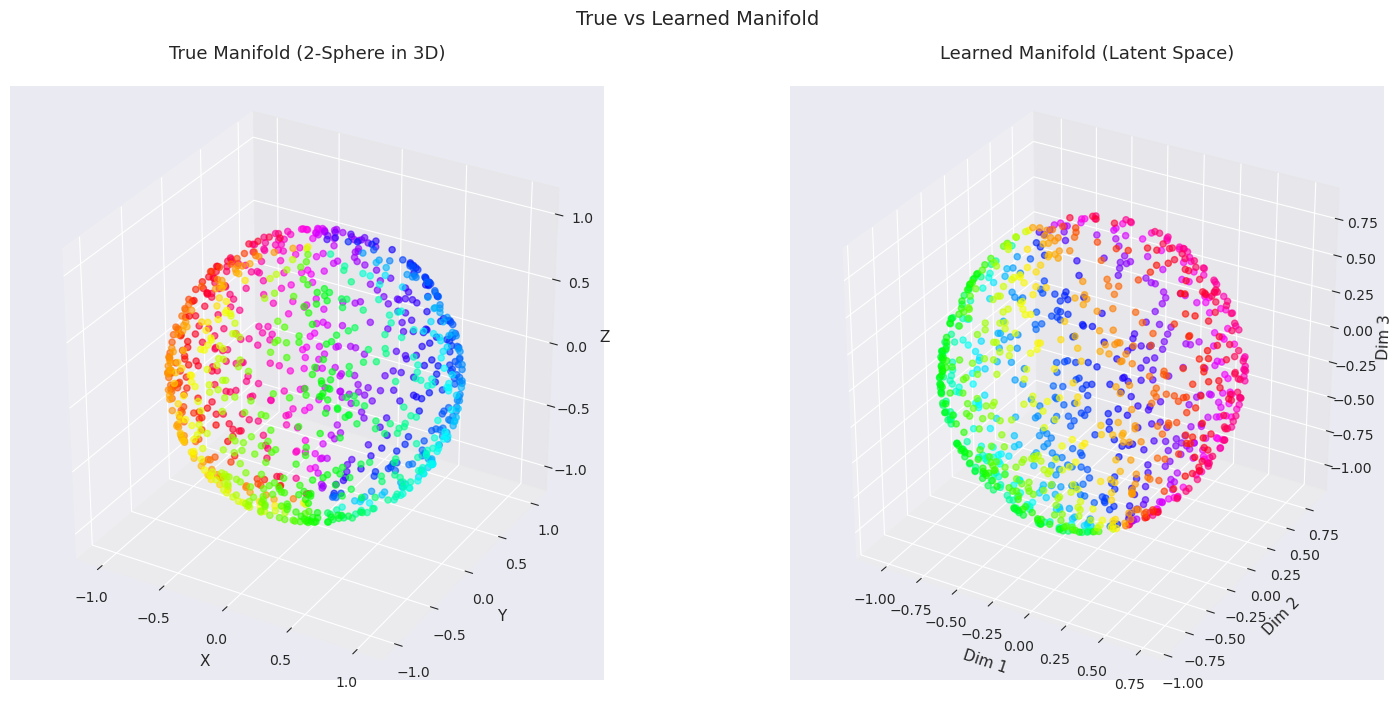

In [135]:
learned_latent = extract_learned_manifold_embedding(
    trained_model_3d, test_data_3d, method='latent'
)

# This shows the sphere in true 3D coords vs learned 2D latent space
# (Needs to add a 3rd dim for visualization - maybe use reconstruction's 3rd dim)
# Or pad latent with zeros:
learned_3d = np.column_stack([learned_latent, np.zeros(len(learned_latent))])
plot_3d_manifolds_comparison(test_coords_3d, learned_3d)

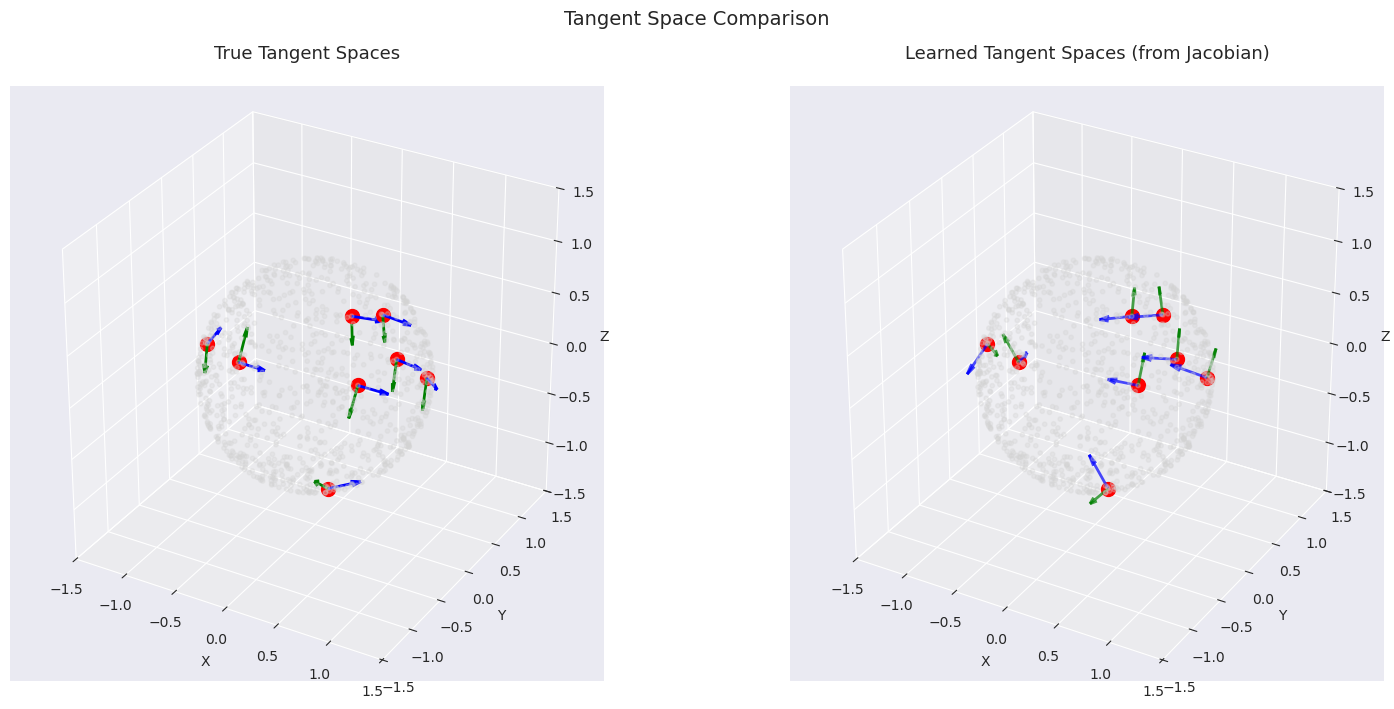

In [139]:
plot_tangent_spaces_3d(
    trained_model_3d, test_data_3d, test_coords_3d,
    n_points=8,  # Show 8 random points
    scale=0.3    # Scale of arrows
)

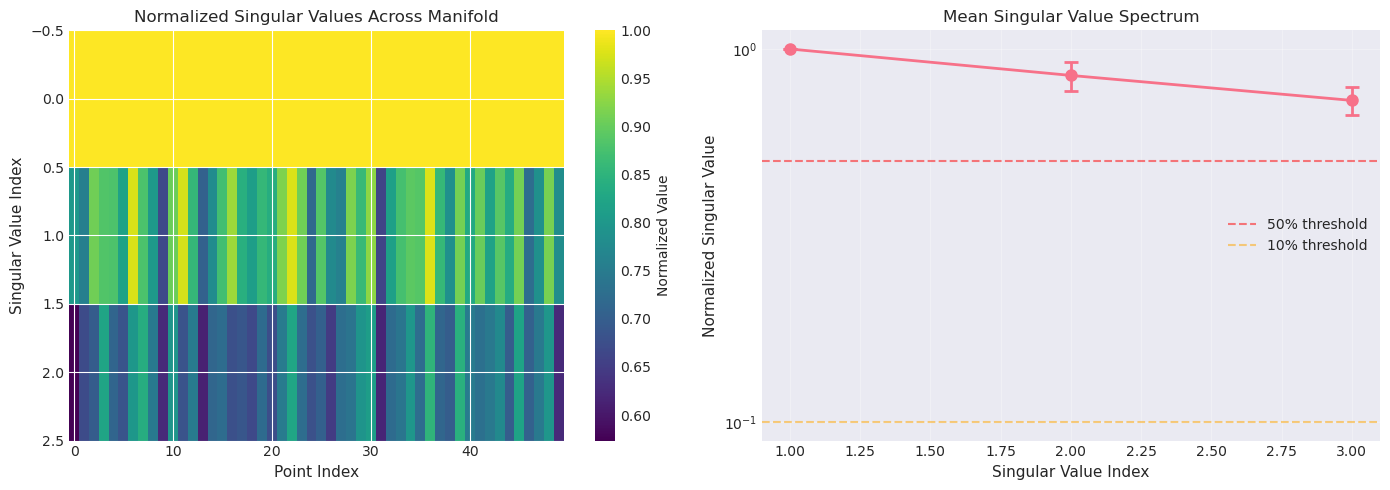


Singular Value Statistics:
Index    Mean         Std          Min          Max         
------------------------------------------------------------
1        1.0000       0.0000       1.0000       1.0000      
2        0.8493       0.0763       0.6612       0.9771      
3        0.7279       0.0640       0.5735       0.8522      


In [140]:
plot_singular_value_heatmap(model_3d, test_data_3d, n_points=50)

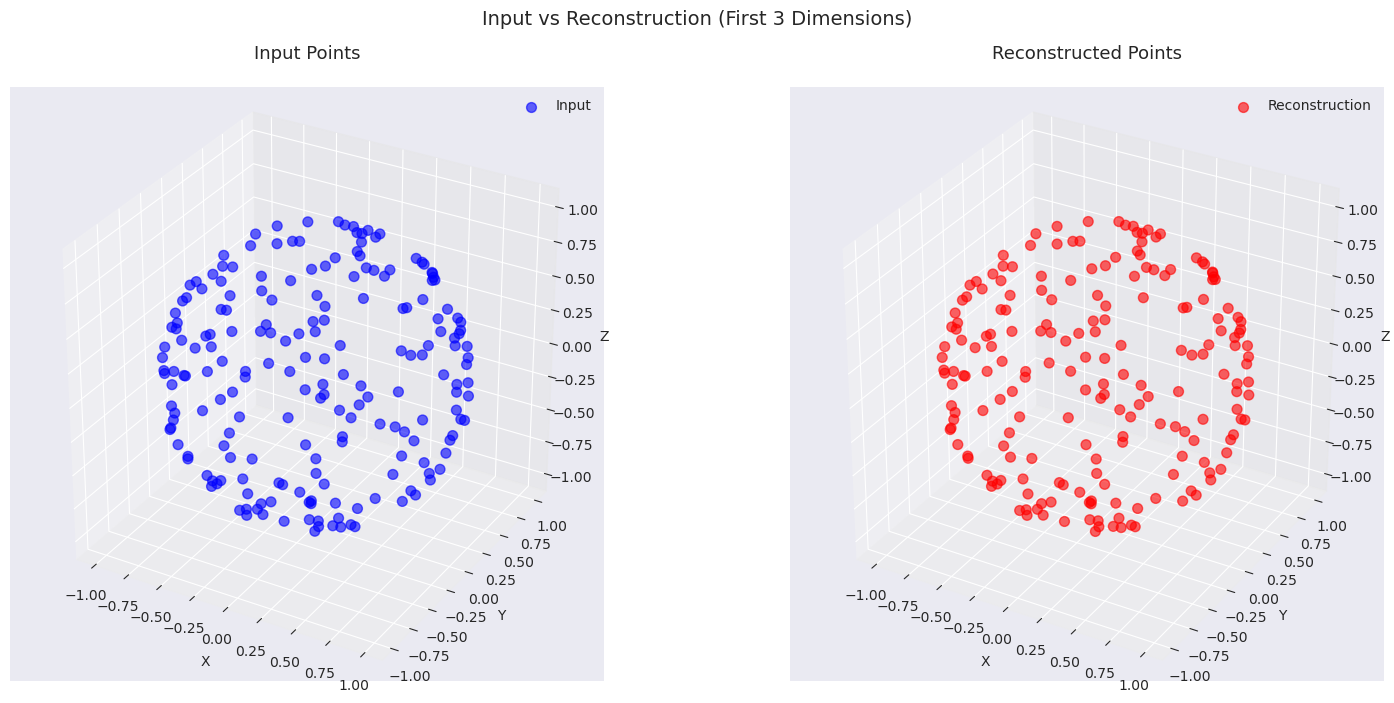


Reconstruction Error Statistics:
  Mean: 0.003803
  Std:  0.001454
  Min:  0.001020
  Max:  0.008477


In [141]:
plot_reconstruction_in_3d(trained_model_3d, test_data_3d, test_coords_3d, n_points=200)

In [142]:
import numpy as np
import torch
from scipy.linalg import svd

def compute_tangent_angles_simple(model, data, intrinsic_dim, n_points=100, device='cpu'):
    """
    Compute principal angles between learned and true tangent spaces.

    Args:
        model: Trained autoencoder
        data: Input data (n_samples, ambient_dim)
        intrinsic_dim: Intrinsic dimension of the manifold
        n_points: Number of points to sample
        device: torch device

    Returns:
        all_angles: Array of shape (n_points, intrinsic_dim) with angles in degrees
        mean_angles: Mean angle for each dimension
        std_angles: Std of angles for each dimension
    """
    model.eval()

    # Sample points
    indices = np.random.choice(len(data), min(n_points, len(data)), replace=False)

    all_angles = []

    for idx in indices:
        point = data[idx]

        # Compute learned tangent space (from Jacobian)
        point_tensor = torch.FloatTensor(point).to(device).unsqueeze(0)
        point_tensor.requires_grad_(True)

        z = model.encode(point_tensor)
        latent_dim = z.shape[1]
        input_dim = point_tensor.shape[1]

        # Compute Jacobian
        jacobian = torch.zeros(latent_dim, input_dim, device=device)
        for i in range(latent_dim):
            if point_tensor.grad is not None:
                point_tensor.grad.zero_()

            output = torch.zeros_like(z)
            output[0, i] = 1.0
            z.backward(output, retain_graph=True)
            jacobian[i] = point_tensor.grad[0].clone()

        # SVD to get tangent space
        J_np = jacobian.detach().cpu().numpy()
        U, S, Vt = svd(J_np, full_matrices=False)
        tangent_learned = Vt[:intrinsic_dim, :]  # Top intrinsic_dim vectors

        # Compute true tangent space (perpendicular to radius)
        # For sphere centered at origin, radius = point itself
        # Tangent space = all vectors perpendicular to point

        # Use first (intrinsic_dim + 1) dimensions (where sphere lives)
        active_dims = intrinsic_dim + 1
        point_active = point[:active_dims]

        # Radius direction (normalized)
        radius_direction = point_active / np.linalg.norm(point_active)

        # Generate orthonormal basis for tangent space
        tangent_true = []
        for i in range(active_dims):
            v = np.zeros(active_dims)
            v[i] = 1.0

            # Remove component along radius
            v_tangent = v - np.dot(v, radius_direction) * radius_direction

            norm = np.linalg.norm(v_tangent)
            if norm > 1e-10:
                v_tangent = v_tangent / norm
                tangent_true.append(v_tangent)

        tangent_true = np.array(tangent_true[:intrinsic_dim])

        # Embed back in full ambient space
        tangent_true_full = np.zeros((intrinsic_dim, len(point)))
        tangent_true_full[:, :active_dims] = tangent_true

        # Compute principal angles
        Q1, _ = np.linalg.qr(tangent_learned.T)
        Q2, _ = np.linalg.qr(tangent_true_full.T)

        M = Q1.T @ Q2
        _, S_angles, _ = svd(M)
        S_angles = np.clip(S_angles, 0, 1)

        angles = np.arccos(S_angles)
        angles_deg = np.degrees(angles)

        all_angles.append(angles_deg)

    all_angles = np.array(all_angles)
    mean_angles = np.mean(all_angles, axis=0)
    std_angles = np.std(all_angles, axis=0)

    # Print results
    print(f"Results across {n_points} test points:")
    print(f"\nAll principal angles (mean across points, in degrees):")
    for i in range(intrinsic_dim):
        print(f"  Angle {i+1:2d}: {mean_angles[i]:6.4f}° ± {std_angles[i]:6.4f}°")

    print(f"\nSubspace distances (max principal angle in degrees):")
    max_angles = np.max(all_angles, axis=1)
    print(f"  Mean: {np.mean(max_angles):.4f}°")
    print(f"  Std:  {np.std(max_angles):.4f}°")
    print(f"  Min:  {np.min(max_angles):.4f}°")
    print(f"  Max:  {np.max(max_angles):.4f}°")

    return all_angles, mean_angles, std_angles

In [144]:
all_angles, mean_angles, std_angles = compute_tangent_angles_simple(
    model=trained_model_3d,  # latent_dim=3 model
    data=test_data_3d,
    intrinsic_dim=3,
    n_points=100,
    device=device
)

Results across 100 test points:

All principal angles (mean across points, in degrees):
  Angle  1: 5.8021° ± 1.5167°
  Angle  2: 9.0100° ± 1.4959°
  Angle  3: 12.3598° ± 1.7941°

Subspace distances (max principal angle in degrees):
  Mean: 12.3598°
  Std:  1.7941°
  Min:  8.2342°
  Max:  17.7918°
